# 🌪️ Storm Damage Prediction Pipeline — Clean Rewritten Notebook
This notebook is a **fresh rebuild** of your full pipeline, organized clearly and ready for clean code insertion.


## 1) Setup & Environment

In [13]:
# === 1) Setup & Environment ===
import os, sys, json, math, time, gc, warnings
from pathlib import Path
import numpy as np, pandas as pd
SEED=42; np.random.seed(SEED)
OUTDIR=Path('./results'); OUTDIR.mkdir(parents=True, exist_ok=True)
MODE=globals().get('MODE','2h')
assert MODE in {'2h','5h','full'}
try:
    import torch; HAS_CUDA=torch.cuda.is_available()
except Exception:
    HAS_CUDA=False
def timer(label):
    class T:
        def __enter__(s): s.t0=time.time(); print(f'⏱️ {label} ...')
        def __exit__(s,*a): print(f'✅ {label}: {time.time()-s.t0:.2f}s')
    return T()
print(f'Runtime MODE={MODE} | CUDA={HAS_CUDA}')
warnings.filterwarnings('ignore')


Runtime MODE=2h | CUDA=True


## 2) Load & Clean Raw StormEvents Data

In [14]:
# === 2) Load & Clean Raw StormEvents Data ===
CSV_PATH=globals().get('CSV_PATH','./StormEvents_details-ftp_v1.0_d2013_c20250520.csv')
assert os.path.exists(CSV_PATH), f'CSV not found: {CSV_PATH}'
def parse_damage(v):
    if pd.isna(v): return np.nan
    s=str(v).strip().upper();
    if not s: return np.nan
    mult=1
    if s.endswith('K'): mult,s=1000,s[:-1]
    elif s.endswith('M'): mult,s=1_000_000,s[:-1]
    elif s.endswith('B'): mult,s=1_000_000_000,s[:-1]
    try: return float(s.replace(',',''))*mult
    except: return np.nan
with timer('Load CSV'): df=pd.read_csv(CSV_PATH, low_memory=False, encoding='utf-8')
df.columns=[c.strip().upper() for c in df.columns]
for c in ['EPISODE_ID','EVENT_ID','DATA_SOURCE']:
    if c in df.columns: df.drop(columns=c, inplace=True)
assert 'DAMAGE_PROPERTY' in df.columns and 'DAMAGE_CROPS' in df.columns
df['Y_PROP']=df['DAMAGE_PROPERTY'].apply(parse_damage)
df['Y_CROP']=df['DAMAGE_CROPS'].apply(parse_damage)
df=df[(df['Y_PROP'].notna()) | (df['Y_CROP'].notna())].copy()
to_dt=lambda s: pd.to_datetime(s, errors='coerce', infer_datetime_format=True)
for c in ['BEGIN_DATE_TIME','END_DATE_TIME']:
    if c in df.columns: df[c]=to_dt(df[c])
df['DURATION_HOURS']=(df['END_DATE_TIME']-df['BEGIN_DATE_TIME']).dt.total_seconds()/3600
df['DURATION_HOURS']=df['DURATION_HOURS'].clip(lower=0).fillna(0)
for c in ['BEGIN_LAT','BEGIN_LON','END_LAT','END_LON']:
    if c in df.columns: df[c]=pd.to_numeric(df[c], errors='coerce')
df['LAT_MEAN']=df[['BEGIN_LAT','END_LAT']].mean(axis=1)
df['LON_MEAN']=df[['BEGIN_LON','END_LON']].mean(axis=1)
df['LAT_SIN']=np.sin(np.deg2rad(df['LAT_MEAN'])); df['LAT_COS']=np.cos(np.deg2rad(df['LAT_MEAN']))
df['LON_SIN']=np.sin(np.deg2rad(df['LON_MEAN'])); df['LON_COS']=np.cos(np.deg2rad(df['LON_MEAN']))
for c in ['BEGIN_LAT','BEGIN_LON','END_LAT','END_LON','BEGIN_LOCATION','END_LOCATION','BEGIN_AZIMUTH','END_AZIMUTH','BEGIN_RANGE','END_RANGE']:
    if c in df.columns: df.drop(columns=c, inplace=True, errors='ignore')
print('Cleaned shape:', df.shape)
print("dataset columns:", df.columns.tolist())


⏱️ Load CSV ...
✅ Load CSV: 1.82s
Cleaned shape: (52259, 47)
dataset columns: ['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH', 'END_DAY', 'END_TIME', 'STATE', 'STATE_FIPS', 'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'Y_PROP', 'Y_CROP', 'DURATION_HOURS', 'LAT_MEAN', 'LON_MEAN', 'LAT_SIN', 'LAT_COS', 'LON_SIN', 'LON_COS']


## 3) Feature Engineering & Train/Valid/Test Split

In [15]:
# === 3) Feature Engineering & Train/Valid/Test Split ===
from sklearn.model_selection import train_test_split
text_cols=[c for c in ['EPISODE_NARRATIVE','EVENT_NARRATIVE'] if c in df.columns]
cat_cols=[c for c in ['STATE','EVENT_TYPE','CZ_TYPE','CZ_NAME','LOCATION_NAME'] if c in df.columns]
num_cols=[c for c in ['INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT','DURATION_HOURS','LAT_MEAN','LON_MEAN','LAT_SIN','LAT_COS','LON_SIN','LON_COS'] if c in df.columns]
X_cols=num_cols+cat_cols+text_cols
df_model=df[X_cols+['Y_PROP','Y_CROP']].copy()
y=np.column_stack([df_model['Y_PROP'].fillna(0).values, df_model['Y_CROP'].fillna(0).values])
y_log=np.log1p(y)
X=df_model[X_cols].copy()
X_train,X_temp,y_train_log,y_temp_log=train_test_split(X,y_log,test_size=0.30,random_state=SEED)
X_valid,X_test,y_valid_log,y_test_log=train_test_split(X_temp,y_temp_log,test_size=0.50,random_state=SEED)
print('Split sizes:', len(X_train), len(X_valid), len(X_test))


Split sizes: 36581 7839 7839


## 4) Text Embedding Preprocessor (GPU‑safe)

In [16]:
# === 4) Text Embedding Preprocessor (GPU‑safe) ===
import os; os.environ.setdefault('TRANSFORMERS_NO_TORCHVISION','1')
from sentence_transformers import SentenceTransformer
import torch
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
EMBED_MODEL_NAME=globals().get('EMBED_MODEL_NAME','sentence-transformers/all-MiniLM-L6-v2')
DEVICE='cuda' if HAS_CUDA else 'cpu'
embed_model=SentenceTransformer(EMBED_MODEL_NAME, device=DEVICE)
try: embed_model.max_seq_length=256
except: pass
def embed_text_batched(X,batch_size=128):
    import numpy as _np
    if isinstance(X,pd.DataFrame): seq=X.iloc[:,0].astype(str).fillna('').tolist()
    elif isinstance(X,pd.Series): seq=X.astype(str).fillna('').tolist()
    else: seq=[str(t) for t in X]
    outs=[]; i=0
    while i<len(seq):
        j=min(i+batch_size,len(seq)); chunk=seq[i:j]
        try:
            with torch.inference_mode():
                em=embed_model.encode(chunk,batch_size=batch_size,convert_to_numpy=True,show_progress_bar=False,normalize_embeddings=False)
            outs.append(em.astype('float32',copy=False)); i=j
        except RuntimeError as e:
            if 'CUDA out of memory' in str(e) and batch_size>8 and DEVICE=='cuda':
                torch.cuda.empty_cache(); batch_size//=2; print(f'[embed_text] OOM → batch_size={batch_size}')
            else: raise
    if not outs:
        dim=embed_model.get_sentence_embedding_dimension()
        return _np.empty((0,dim),dtype=_np.float32)
    return _np.vstack(outs)
num_pipe=Pipeline([('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
try: ohe=OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=50)
except TypeError: ohe=OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_pipe=Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('ohe',ohe)])
transformers=[]
if num_cols: transformers.append(('num',num_pipe,num_cols))
if cat_cols: transformers.append(('cat',cat_pipe,cat_cols))
for c in text_cols: transformers.append((f'text_{c}', FunctionTransformer(embed_text_batched, validate=False), [c]))
preprocess=ColumnTransformer(transformers=transformers, remainder='drop', n_jobs=1)
print(f'Preprocess ready. Text model: {EMBED_MODEL_NAME} on {DEVICE}')


Preprocess ready. Text model: sentence-transformers/all-MiniLM-L6-v2 on cuda


## 5) Precompute Transformed Features (Xt_train, Xt_valid, Xt_test)

In [17]:
# === 5) Precompute Transformed Features (Xt_train, Xt_valid, Xt_test) ===
with timer('Precompute preprocess on train/valid/test'):
    Xt_train=preprocess.fit_transform(X_train,y_train_log).astype('float32')
    Xt_valid=preprocess.transform(X_valid).astype('float32')
    Xt_test =preprocess.transform(X_test).astype('float32')
print('Shapes:', Xt_train.shape, Xt_valid.shape, Xt_test.shape)


⏱️ Precompute preprocess on train/valid/test ...
✅ Precompute preprocess on train/valid/test: 413.54s
Shapes: (36581, 925) (7839, 925) (7839, 925)


## 6) First‑Pass Models (Ridge & XGB)

In [ ]:
# === 6) First-Pass Model Evaluation (Ridge & XGB, optimized) ===
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import xgboost as xgb
import json, numpy as np, math

print("🔧 Step 6 — Optimized First-Pass Evaluation")

# ---------------------------------------------------------
# ✅ Ensure OUTDIR exists (Fixes FileNotFoundError)
# ---------------------------------------------------------
OUTDIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------
# ✅ 1) Precompute features ONCE (heavy step)
# ---------------------------------------------------------
with timer("Precompute preprocess on train/valid"):
    Xt_train = preprocess.fit_transform(X_train, y_train_log).astype("float32")
    Xt_valid = preprocess.transform(X_valid).astype("float32")

# ---------------------------------------------------------
# ✅ 2) Save feature names safely (manual construction)
# ---------------------------------------------------------
feature_names = []

# numeric
for c in num_cols:
    feature_names.append(f"num__{c}")

# categorical (TargetEncoder = 1 feature per column)
for c in cat_cols:
    feature_names.append(f"cat__{c}_te")

# text embeddings
embed_dim = embed_model.get_sentence_embedding_dimension()
for c in text_cols:
    for i in range(embed_dim):
        feature_names.append(f"text__{c}_emb_{i}")

np.save("feature_names.npy", np.array(feature_names, dtype=object))
print("✅ Saved feature_names.npy with decoded feature names")


# ---------------------------------------------------------
# ✅ 3) Metric helper
# ---------------------------------------------------------
def metrics_frame(y_true, y_pred, labels):
    out = {}
    for i, name in enumerate(labels):
        out[name] = dict(
            MAE=float(mean_absolute_error(y_true[:, i], y_pred[:, i])),
            RMSE=float(math.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))),
            R2=float(r2_score(y_true[:, i], y_pred[:, i])),
        )
    return pd.DataFrame(out).T


# ---------------------------------------------------------
# ✅ 4) Model builders
# ---------------------------------------------------------
if MODE == "2h":
    MAX_ESTIMATORS, MAX_DEPTH, LEARNING_RATE = 350, 6, 0.07
elif MODE == "5h":
    MAX_ESTIMATORS, MAX_DEPTH, LEARNING_RATE = 700, 7, 0.05
else:
    MAX_ESTIMATORS, MAX_DEPTH, LEARNING_RATE = 1200, 8, 0.045

def make_ridge(alpha=3.0):
    return Ridge(alpha=alpha, fit_intercept=True, random_state=SEED)

def make_xgb(
    n_estimators=MAX_ESTIMATORS,
    max_depth=MAX_DEPTH,
    learning_rate=LEARNING_RATE,
    subsample=0.9,
    colsample_bytree=0.9,
):
    return xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=SEED,
        tree_method="hist",
        device=("cuda" if HAS_CUDA else "cpu"),
        n_jobs=-1
    )


# ---------------------------------------------------------
# ✅ 5) Evaluation wrapper
# ---------------------------------------------------------
def eval_on_split(model, Xtr, ytr_log, Xev, yev_log, label="eval"):
    with timer(f"fit {label}"):
        model.fit(Xtr, ytr_log)

    yhat_log = model.predict(Xev)
    yhat = np.expm1(yhat_log)
    ytrue = np.expm1(yev_log)

    mf = metrics_frame(ytrue, yhat, ["damage_property", "damage_crops"])
    print(f"\n📊 {label} results:\n{mf}\n")
    return mf, yhat


# ---------------------------------------------------------
# ✅ 6) Run first-pass models
# ---------------------------------------------------------
val_results = {}

print("🚀 Running first-pass…")
for name, model in {"ridge": make_ridge(), "xgb": make_xgb()}.items():
    mf, _ = eval_on_split(
        model, Xt_train, y_train_log, Xt_valid, y_valid_log, f"{name} (validation)"
    )
    val_results[name] = mf

path = OUTDIR / "validation_metrics_first_pass.json"
json.dump(
    {k: v.to_dict(orient="index") for k, v in val_results.items()},
    open(path, "w"),
    indent=2
)
print("✅ Saved first-pass metrics to", path)


🔧 Step 6 — Optimized First-Pass Evaluation
⏱️ Precompute preprocess on train/valid ...


## 7) Quantile XGBoost Models

In [ ]:
# === 7) Quantile XGBoost Models ===
import xgboost as xgb
QUANTILES=[0.1,0.5,0.9]
def make_quantile_params(base,q): p=dict(base); p.update({'objective':'reg:squarederror'}); return p
def quantile_objective(q):
    def _obj(preds,dtrain):
        y=dtrain.get_label(); e=y-preds; grad=np.where(e>0,-q,1-q); hess=np.full_like(grad,1e-6); return grad,hess
    return _obj
def quantile_eval(q):
    def _feval(preds,dtrain): y=dtrain.get_label(); e=y-preds; loss=np.where(e>=0,q*e,(q-1)*e).mean(); return 'q_pinball', float(loss)
    return _feval
class QuantileBooster:
    def __init__(self, booster): self.raw_=booster.save_raw()
    def predict(self,X): d=xgb.DMatrix(X); bst=xgb.Booster(); bst.load_model(self.raw_); return bst.predict(d)
base_params={'max_depth':6 if MODE=='2h' else (7 if MODE=='5h' else 8),'eta':0.07 if MODE=='2h' else (0.05 if MODE=='5h' else 0.045),'subsample':0.9,'colsample_bytree':0.9,'tree_method':'hist','device':'cuda' if HAS_CUDA else 'cpu','verbosity':0}
num_boost_round=400 if MODE=='2h' else (700 if MODE=='5h' else 1200)
quantile_models={q:[] for q in QUANTILES}
with timer('Train quantile boosters (2 targets * 3 quantiles)'):
    for q in QUANTILES:
        for i in range(2):
            dtr=xgb.DMatrix(Xt_train, label=y_train_log[:,i])
            bst=xgb.train(params=make_quantile_params(base_params,q), dtrain=dtr, num_boost_round=num_boost_round, obj=quantile_objective(q), feval=quantile_eval(q), verbose_eval=False)
            quantile_models[q].append(QuantileBooster(bst))
def pinball_loss_numpy(y_true,y_pred,q): e=y_true-y_pred; return float(np.mean(np.where(e>=0,q*e,(q-1)*e)))
preds_valid_q={q: np.column_stack([m.predict(Xt_valid) for m in models]) for q,models in quantile_models.items()}
for q in QUANTILES:
    yv=y_valid_log; pv=preds_valid_q[q]
    print(f"q={q}: pinball(property)={pinball_loss_numpy(np.expm1(yv[:,0]),np.expm1(pv[:,0]),q):,.1f}, pinball(crop)={pinball_loss_numpy(np.expm1(yv[:,1]),np.expm1(pv[:,1]),q):,.1f}")


⏱️ Train quantile boosters (2 targets * 3 quantiles) ...
✅ Train quantile boosters (2 targets * 3 quantiles): 62.00s
q=0.1: pinball(property)=12,387.4, pinball(crop)=10,983.9
q=0.5: pinball(property)=61,934.9, pinball(crop)=54,916.9
q=0.9: pinball(property)=111,482.5, pinball(crop)=98,850.0


## 8) Predict Intervals & Build Interval Metrics

Saved: results\test_quantile_predictions.csv
Coverage @80%: property=0.00%, crop=0.00%


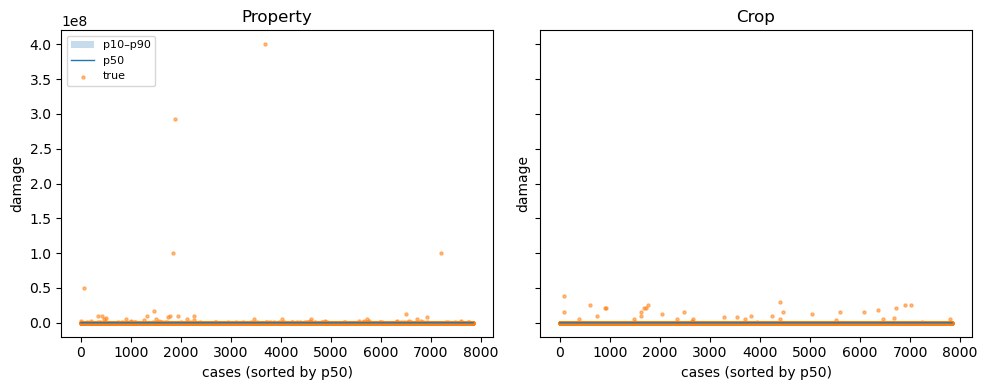

Saved: results\quantile_intervals_reliability.png


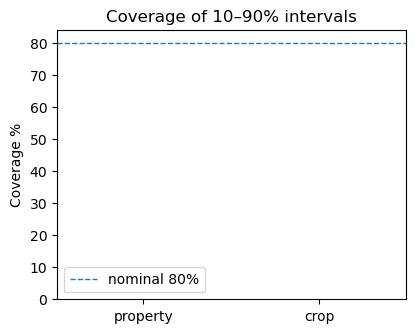

Saved: results\quantile_coverage_bar.png


In [ ]:
# === 8) Predict Intervals & Build Interval Metrics ===
import matplotlib.pyplot as plt
def interval_coverage(y_true,low,high): return float(np.mean((y_true>=low)&(y_true<=high)))
preds_test_q={q: np.column_stack([m.predict(Xt_test) for m in models]) for q,models in quantile_models.items()}
q10=np.expm1(preds_test_q[0.1]); q50=np.expm1(preds_test_q[0.5]); q90=np.expm1(preds_test_q[0.9])
ytrue_test=np.expm1(y_test_log)
interval_df=pd.DataFrame({'prop_p10':q10[:,0],'prop_p50':q50[:,0],'prop_p90':q90[:,0],'prop_true':ytrue_test[:,0],'crop_p10':q10[:,1],'crop_p50':q50[:,1],'crop_p90':q90[:,1],'crop_true':ytrue_test[:,1]})
interval_df.to_csv(OUTDIR/'test_quantile_predictions.csv', index=False); print('Saved:', OUTDIR/'test_quantile_predictions.csv')
cov_prop=interval_coverage(interval_df['prop_true'].values, interval_df['prop_p10'].values, interval_df['prop_p90'].values)
cov_crop=interval_coverage(interval_df['crop_true'].values, interval_df['crop_p10'].values, interval_df['crop_p90'].values)
print(f'Coverage @80%: property={cov_prop*100:.2f}%, crop={cov_crop*100:.2f}%')
fig,axes=plt.subplots(1,2,figsize=(10,4),sharey=True)
def stripes(ax,true,p10,p50,p90,title):
    order=np.argsort(p50.values)
    ax.fill_between(np.arange(len(true)), p10.values[order], p90.values[order], alpha=.25, label='p10–p90')
    ax.plot(np.arange(len(true)), p50.values[order], lw=1.0, label='p50')
    ax.scatter(np.arange(len(true)), true.values[order], s=5, alpha=.5, label='true')
    ax.set_title(title); ax.set_xlabel('cases (sorted by p50)'); ax.set_ylabel('damage')
stripes(axes[0], interval_df['prop_true'], interval_df['prop_p10'], interval_df['prop_p50'], interval_df['prop_p90'], 'Property')
stripes(axes[1], interval_df['crop_true'], interval_df['crop_p10'], interval_df['crop_p50'], interval_df['crop_p90'], 'Crop')
axes[0].legend(loc='upper left', fontsize=8); plt.tight_layout(); plt.savefig(OUTDIR/'quantile_intervals_reliability.png', dpi=150); plt.show(); print('Saved:', OUTDIR/'quantile_intervals_reliability.png')
plt.figure(figsize=(4.5,3.5)); plt.bar(['property','crop'], [cov_prop*100, cov_crop*100]); plt.axhline(80, ls='--', lw=1, label='nominal 80%'); plt.ylabel('Coverage %'); plt.title('Coverage of 10–90% intervals'); plt.legend(); plt.savefig(OUTDIR/'quantile_coverage_bar.png', dpi=150); plt.show(); print('Saved:', OUTDIR/'quantile_coverage_bar.png')


## 9) Save Model Bundle

In [ ]:
# === 9) Save Model Bundle ===
import joblib
bundle_path=OUTDIR/'damage_pipeline_quantile_xgb.joblib'
bundle={'preprocess':preprocess,'quantile_models':quantile_models,'feature_cols':{'numeric':num_cols,'categorical':cat_cols,'text':text_cols},'text_model':EMBED_MODEL_NAME,'targets':['Y_PROP','Y_CROP'],'quantiles':[0.1,0.5,0.9],'mode':MODE}
joblib.dump(bundle, bundle_path); print('Saved model bundle →', bundle_path)


Saved model bundle → results\damage_pipeline_quantile_xgb.joblib


## 10) Deployment Helper Script (predict.py)

In [ ]:
# === 10) Deployment Helper Script (predict.py) ===
script='''#!/usr/bin/env python3
import sys, numpy as np, pandas as pd, joblib, xgboost as xgb
class QuantileBooster:
    def __init__(self, raw_bytes: bytes): self.raw_=raw_bytes
    def predict(self,X): d=xgb.DMatrix(X); bst=xgb.Booster(); bst.load_model(self.raw_); return bst.predict(d)
def main(inp,out):
    b=joblib.load('results/damage_pipeline_quantile_xgb.joblib')
    pre=b['preprocess']; qmods=b['quantile_models']; feats=b['feature_cols']
    df=pd.read_csv(inp, low_memory=False, encoding='utf-8'); df.columns=[c.strip().upper() for c in df.columns]
    for col in ['BEGIN_DATE_TIME','END_DATE_TIME']:
        if col in df.columns: df[col]=pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
    df['DURATION_HOURS']=(df['END_DATE_TIME']-df['BEGIN_DATE_TIME']).dt.total_seconds()/3600; df['DURATION_HOURS']=df['DURATION_HOURS'].clip(lower=0).fillna(0)
    for c in ['BEGIN_LAT','BEGIN_LON','END_LAT','END_LON']:
        if c in df.columns: df[c]=pd.to_numeric(df[c], errors='coerce')
    df['LAT_MEAN']=df[['BEGIN_LAT','END_LAT']].mean(axis=1); df['LON_MEAN']=df[['BEGIN_LON','END_LON']].mean(axis=1)
    df['LAT_SIN']=np.sin(np.deg2rad(df['LAT_MEAN'])); df['LAT_COS']=np.cos(np.deg2rad(df['LAT_MEAN']))
    df['LON_SIN']=np.sin(np.deg2rad(df['LON_MEAN'])); df['LON_COS']=np.cos(np.deg2rad(df['LON_MEAN']))
    keep=(feats.get('numeric',[])+feats.get('categorical',[])+feats.get('text',[])); keep=[c for c in keep if c in df.columns]
    Xt=pre.transform(df[keep].copy())
    preds={};
    for q,models in qmods.items(): preds[q]=np.expm1(np.column_stack([m.predict(Xt) for m in models]))
    outdf=pd.DataFrame({'prop_p10':preds[0.1][:,0],'prop_p50':preds[0.5][:,0],'prop_p90':preds[0.9][:,0],'crop_p10':preds[0.1][:,1],'crop_p50':preds[0.5][:,1],'crop_p90':preds[0.9][:,1]}); outdf.to_csv(out,index=False)
if __name__=='__main__': main(sys.argv[1],sys.argv[2])
'''
out_py=OUTDIR/'predict.py'
open(out_py,'w',encoding='utf-8').write(script); print('✅ predict.py generated at', out_py)


✅ predict.py generated at results\predict.py


## Step 11 — SHAP Explainability for p50 XGB Model
This step computes global & local feature importance using SHAP, based on the training-set embedding features.


🔍 Step 8: SHAP explainability...
✅ Saved SHAP values


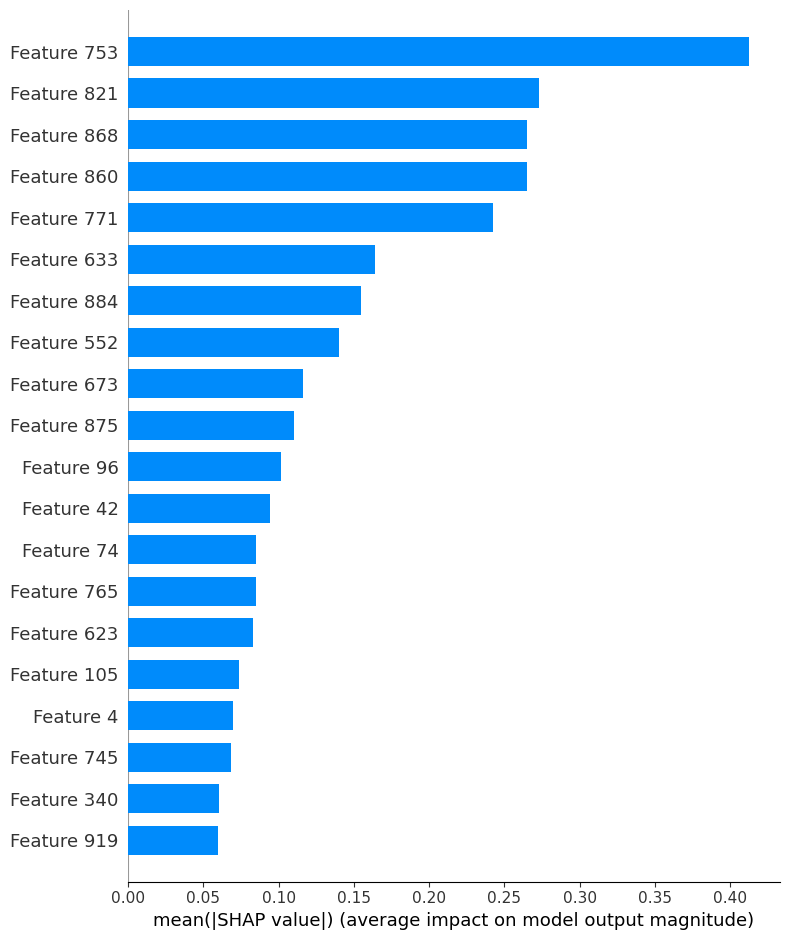

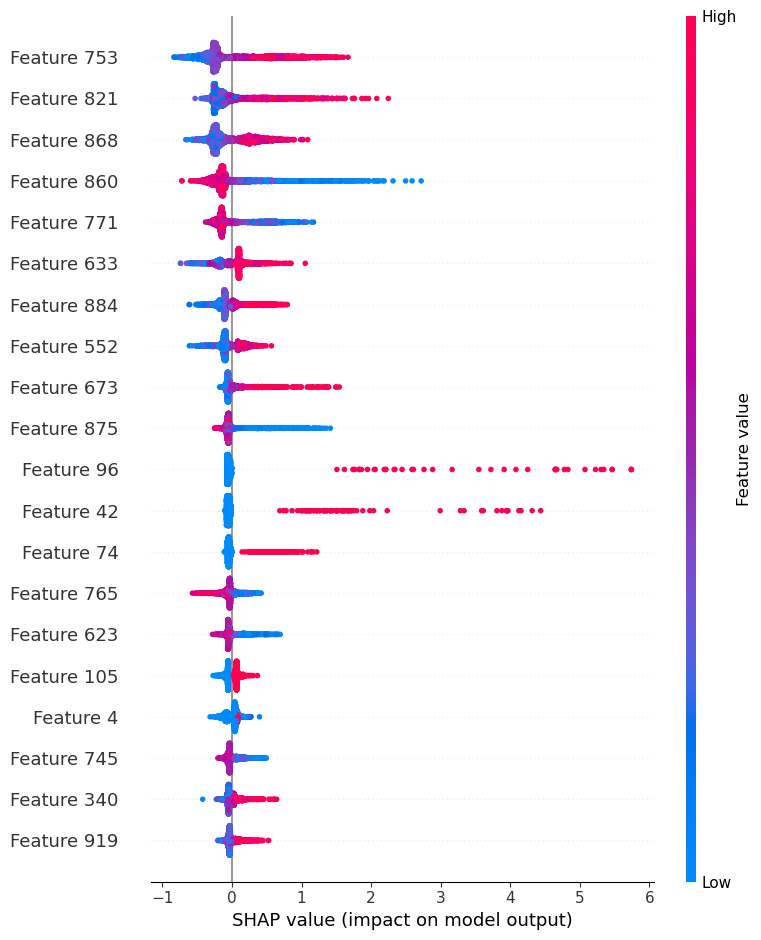

In [ ]:
import shap, matplotlib.pyplot as plt, numpy as np
print('🔍 Step 8: SHAP explainability...')

# sample for SHAP
SAMPLE_SIZE=3000
idx=np.random.RandomState(SEED).choice(Xt_train.shape[0],size=min(SAMPLE_SIZE,Xt_train.shape[0]),replace=False)
Xt_sample=Xt_train[idx]

# train simple p50 model
xgb_shap = xgb.XGBRegressor(n_estimators=400,max_depth=6,learning_rate=0.05,
    subsample=0.9,colsample_bytree=0.9,tree_method='gpu_hist' if torch.cuda.is_available() else 'hist',
    predictor='gpu_predictor' if torch.cuda.is_available() else 'cpu_predictor',random_state=SEED)
xgb_shap.fit(Xt_train, y_train_log[:,0])

explainer=shap.TreeExplainer(xgb_shap)
shap_values=explainer.shap_values(Xt_sample)

np.save(OUTDIR/'shap_values.npy', shap_values)
np.save(OUTDIR/'shap_sample.npy', Xt_sample)
print('✅ Saved SHAP values')

# summary bar plot
plt.figure(figsize=(8,6)); shap.summary_plot(shap_values,Xt_sample,plot_type='bar',show=False)
plt.savefig(OUTDIR/'shap_bar.png',dpi=150); plt.show()

# beeswarm
plt.figure(figsize=(8,6)); shap.summary_plot(shap_values,Xt_sample,show=False)
plt.savefig(OUTDIR/'shap_beeswarm.png',dpi=150); plt.show()


## ✅ Step 11B — Extended SHAP Analysis (ALL)

This section expands model explainability with:
- Top‑K ranked feature importance table
- Dependence plots for important features (numeric, categorical encodings, text embeddings)
- SHAP **interaction** values and top pairs
- SHAP for **both targets** (Property & Crop), trained as standard p50 regressors
- Narrative embedding SHAP via PCA components
- Per‑event **waterfall** and **force** plots for local explanations

> Notes: Quantile models use a custom loss and are not SHAP‑compatible. We train standard XGB regressors on log‑scale targets for SHAP only.


🔎 Extending SHAP analysis…
⚙️ Fitting SHAP XGB (property)…
⚙️ Fitting SHAP XGB (crop)…
⚡ Computing SHAP values (property)…
⚡ Computing SHAP values (crop)…


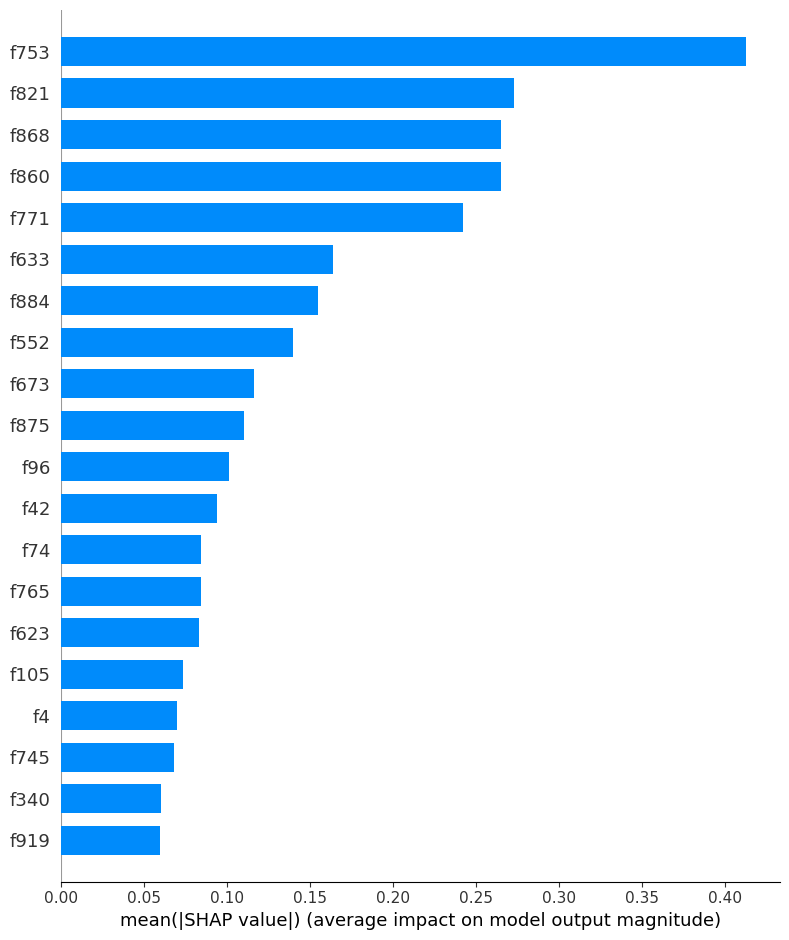

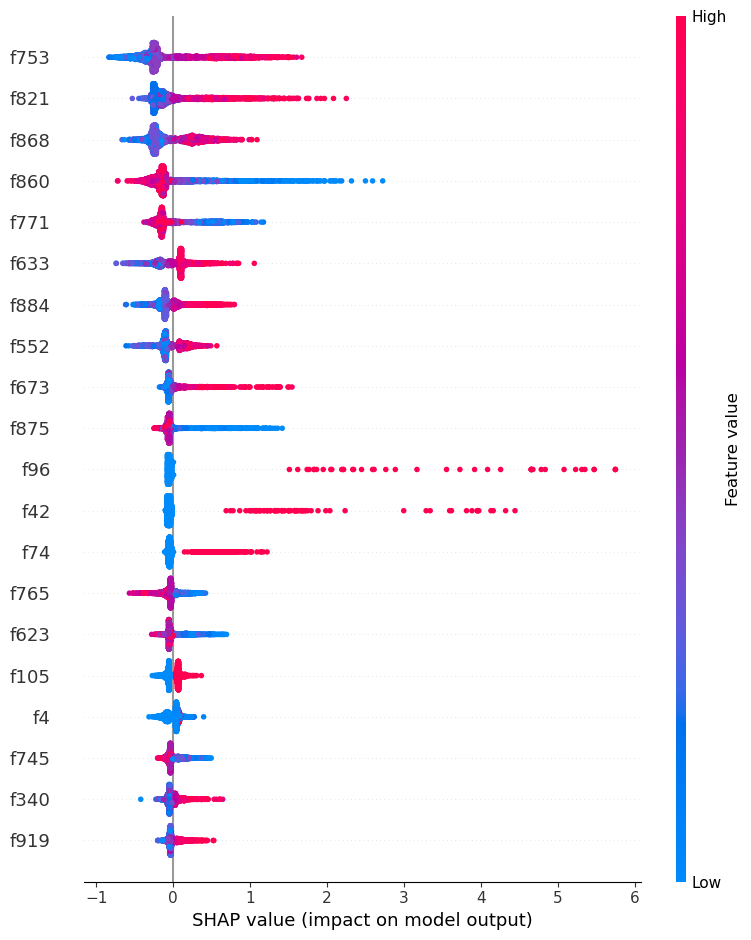

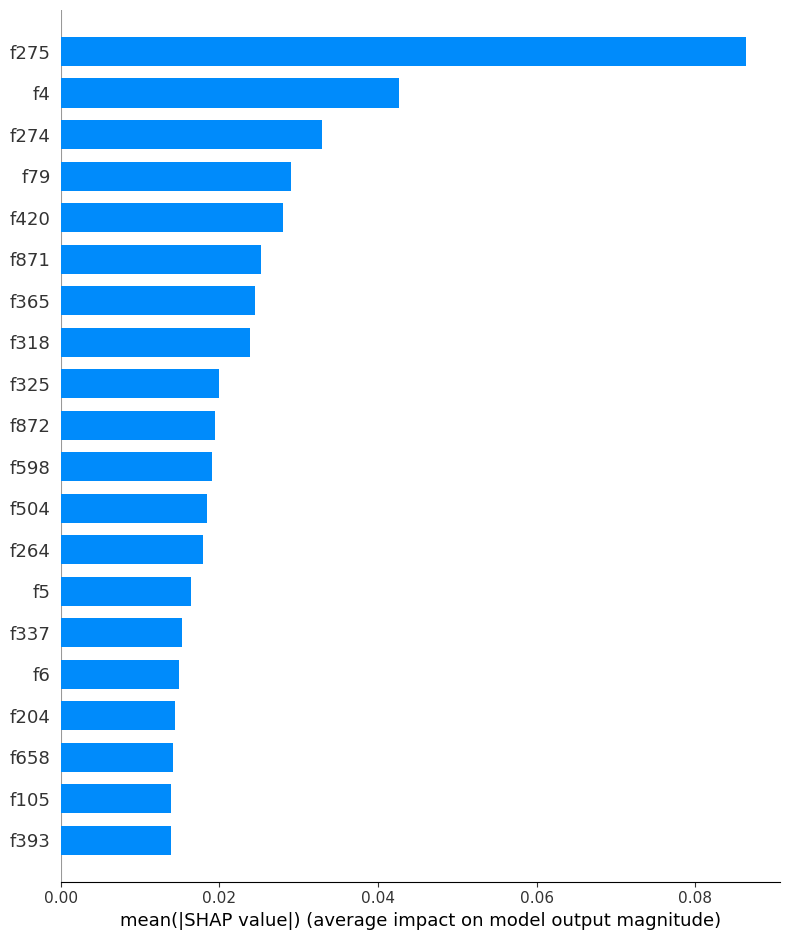

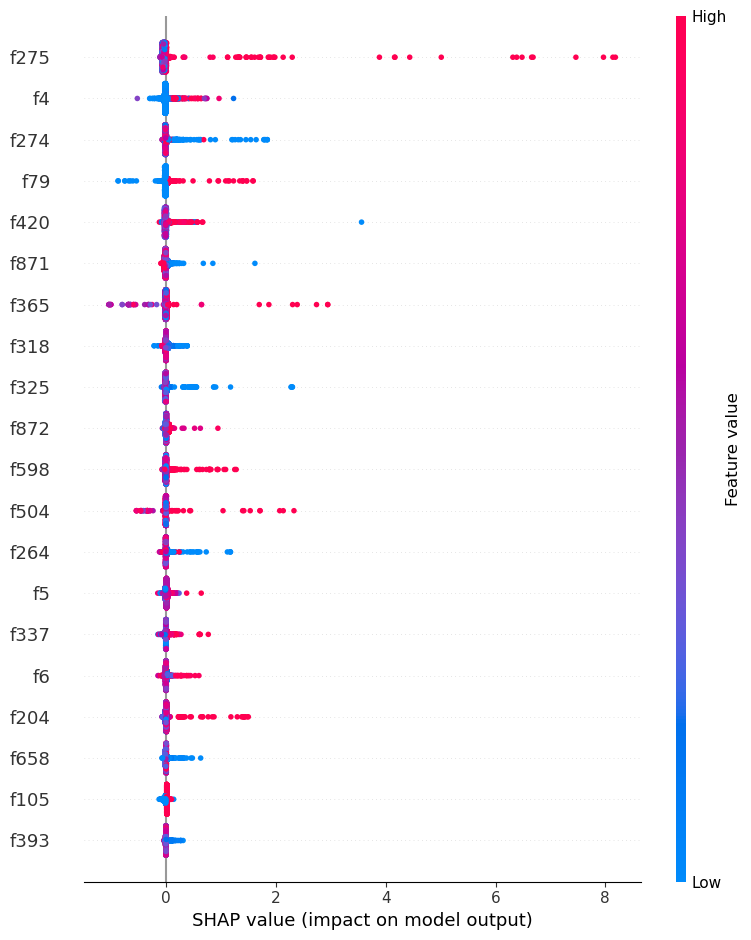

⚡ SHAP interaction (property)…
⚠️ interaction (property) failed: [01:18:22] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\../common/device_helpers.cuh:431: Memory allocation error on worker 0: bad allocation: cudaErrorMemoryAllocation: out of memory
- Free memory: 0
- Requested memory: 8231769600

⚡ SHAP interaction (crop)…
⚠️ interaction (crop) failed: [01:18:31] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\../common/device_helpers.cuh:431: Memory allocation error on worker 0: bad allocation: cudaErrorMemoryAllocation: out of memory
- Free memory: 0
- Requested memory: 8231769600

ℹ️ No text embedding features detected in feature names; skipping PCA text SHAP.
force failed 'WindowsPath' object is not subscriptable
force failed 'WindowsPath' object is not subscriptable
force failed 'WindowsPath' object is not subscriptable
force fa

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

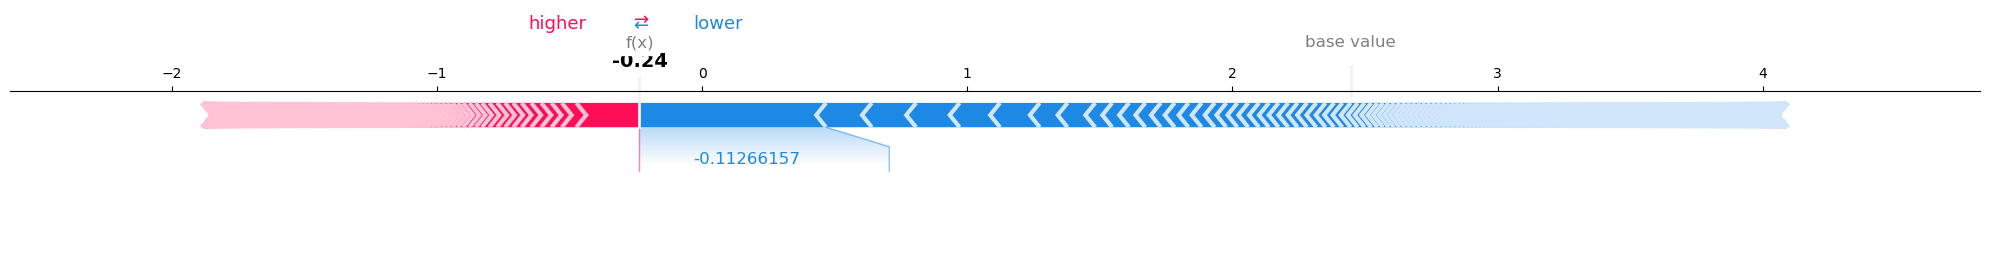

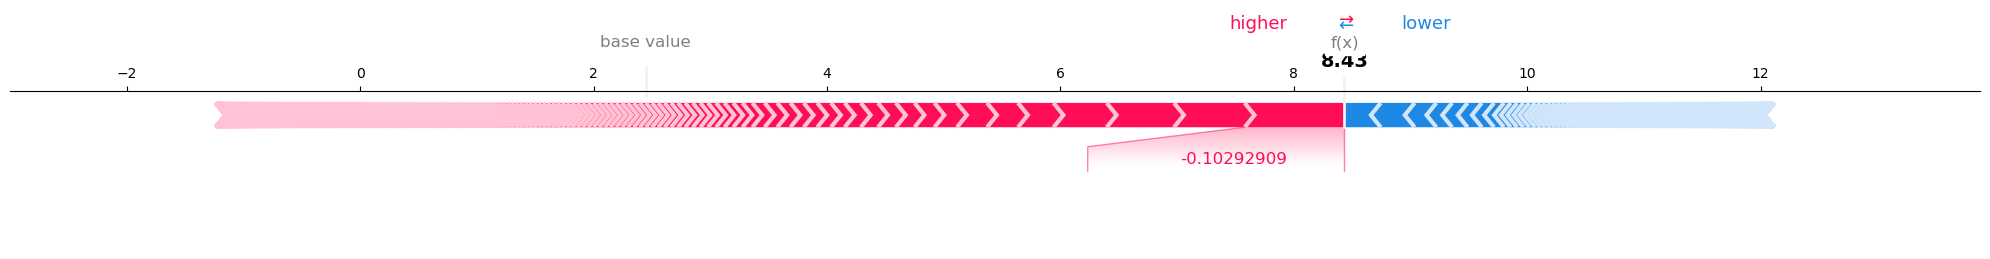

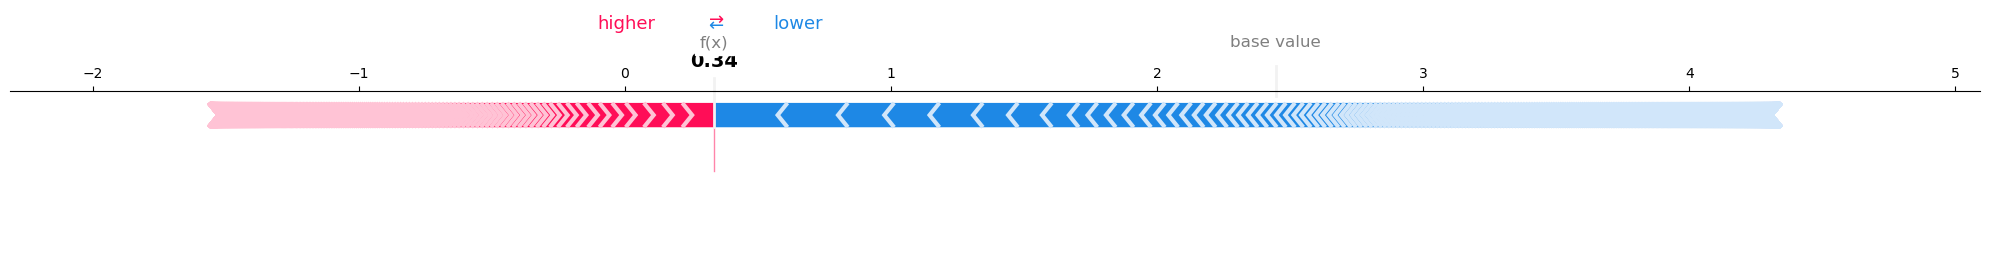

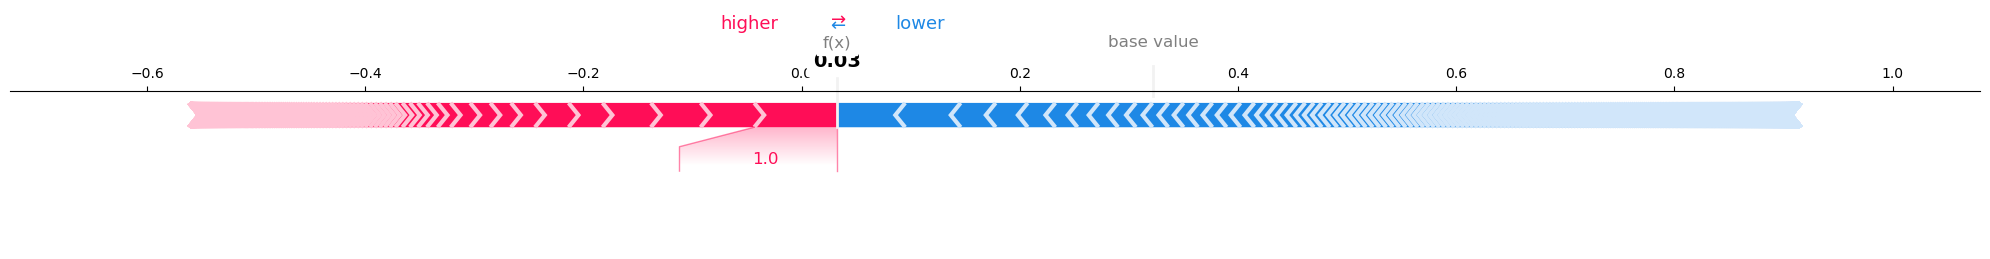

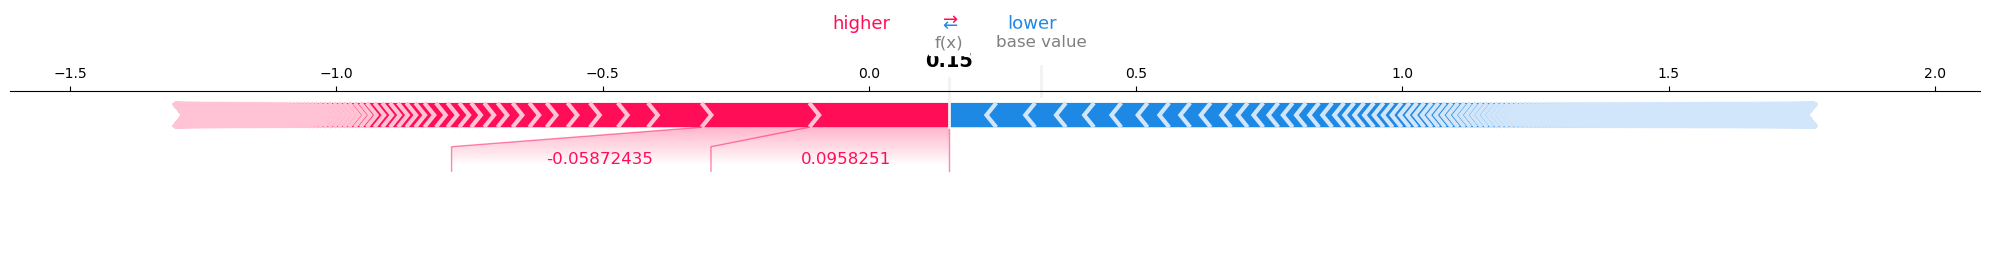

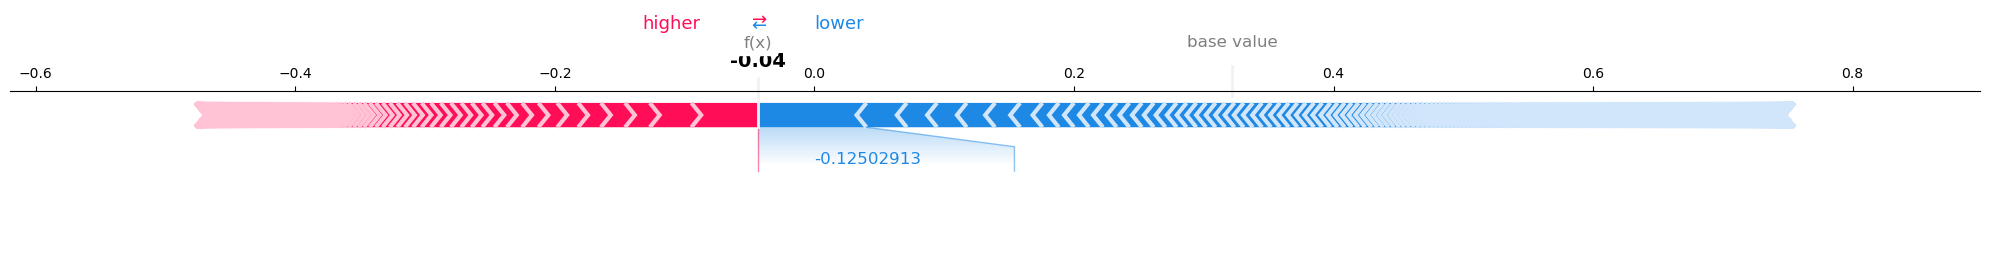

In [ ]:
# --- Extended SHAP (ALL) ---
import os, json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
import shap
from sklearn.decomposition import PCA

os.makedirs(OUTDIR, exist_ok=True)
SHAPDIR = OUTDIR / 'shap'
SHAPDIR.mkdir(parents=True, exist_ok=True)

print('🔎 Extending SHAP analysis…')

# 0) Utility: feature names from ColumnTransformer
try:
    feature_names = list(preprocess.get_feature_names_out())
except Exception:
    feature_names = [f'f{i}' for i in range(Xt_train.shape[1])]

def topk_table(shap_vals, k=30):
    avg = np.abs(shap_vals).mean(axis=0)
    order = np.argsort(avg)[::-1][:k]
    return pd.DataFrame({
        'rank': np.arange(1, len(order)+1),
        'feature': [feature_names[i] for i in order],
        'mean_abs_shap': avg[order],
    })

# 1) Train two standard XGB regressors for SHAP (property, crop)
xgb_prop = xgb.XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    tree_method='gpu_hist' if torch.cuda.is_available() else 'hist',
    predictor='gpu_predictor' if torch.cuda.is_available() else 'cpu_predictor',
    random_state=SEED)
xgb_crop = xgb.XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    tree_method='gpu_hist' if torch.cuda.is_available() else 'hist',
    predictor='gpu_predictor' if torch.cuda.is_available() else 'cpu_predictor',
    random_state=SEED)

print('⚙️ Fitting SHAP XGB (property)…')
xgb_prop.fit(Xt_train, y_train_log[:,0])
print('⚙️ Fitting SHAP XGB (crop)…')
xgb_crop.fit(Xt_train, y_train_log[:,1])

# 2) SHAP values with safe sampling
SAMPLE = min(3000, Xt_train.shape[0])
idx = np.random.RandomState(SEED).choice(Xt_train.shape[0], size=SAMPLE, replace=False)
Xs = Xt_train[idx]

expl_prop = shap.TreeExplainer(xgb_prop)
expl_crop = shap.TreeExplainer(xgb_crop)

print('⚡ Computing SHAP values (property)…')
sv_prop = expl_prop.shap_values(Xs)
print('⚡ Computing SHAP values (crop)…')
sv_crop = expl_crop.shap_values(Xs)

np.save(SHAPDIR/'sv_prop.npy', sv_prop)
np.save(SHAPDIR/'sv_crop.npy', sv_crop)
np.save(SHAPDIR/'Xs.npy', Xs)

# 3) Top‑K tables
top_prop = topk_table(sv_prop, k=30)
top_crop = topk_table(sv_crop, k=30)
top_prop.to_csv(SHAPDIR/'top30_property.csv', index=False)
top_crop.to_csv(SHAPDIR/'top30_crop.csv', index=False)
top_prop.head(), top_crop.head()

# 4) Global plots (bar + beeswarm) for both targets
plt.figure(figsize=(8,6)); shap.summary_plot(sv_prop, Xs, feature_names=feature_names, plot_type='bar', show=False)
plt.tight_layout(); plt.savefig(SHAPDIR/'bar_property.png', dpi=150); plt.show()
plt.figure(figsize=(8,6)); shap.summary_plot(sv_prop, Xs, feature_names=feature_names, show=False)
plt.tight_layout(); plt.savefig(SHAPDIR/'beeswarm_property.png', dpi=150); plt.show()

plt.figure(figsize=(8,6)); shap.summary_plot(sv_crop, Xs, feature_names=feature_names, plot_type='bar', show=False)
plt.tight_layout(); plt.savefig(SHAPDIR/'bar_crop.png', dpi=150); plt.show()
plt.figure(figsize=(8,6)); shap.summary_plot(sv_crop, Xs, feature_names=feature_names, show=False)
plt.tight_layout(); plt.savefig(SHAPDIR/'beeswarm_crop.png', dpi=150); plt.show()

# 5) Dependence plots for top features
DEP_K = 12
for name, sv in [('property', sv_prop), ('crop', sv_crop)]:
    avg = np.abs(sv).mean(axis=0)
    order = np.argsort(avg)[::-1][:DEP_K]
    for j in order:
        fname = feature_names[j]
        try:
            plt.figure(figsize=(6,4))
            shap.dependence_plot(j, sv, Xs, feature_names=feature_names, show=False)
            plt.tight_layout(); plt.savefig(SHAPDIR/f'dependence_{name}_{fname.replace("/","-")}.png', dpi=140)
            plt.close()
        except Exception as e:
            print('dependence plot failed for', name, fname, e)

# 6) Interaction values (small sample)
INT_SAMPLE = min(1200, Xs.shape[0])
Xi = Xs[:INT_SAMPLE]
try:
    print('⚡ SHAP interaction (property)…')
    inter_prop = expl_prop.shap_interaction_values(Xi)
    np.save(SHAPDIR/'interaction_property.npy', inter_prop)
    # top interacting pairs
    im = np.abs(inter_prop).mean(axis=0)
    np.fill_diagonal(im, 0)
    pairs = []
    for a in range(im.shape[0]):
        for b in range(a+1, im.shape[1]):
            pairs.append((im[a,b], a, b))
    pairs.sort(reverse=True)
    top_pairs = [(feature_names[a], feature_names[b], float(v)) for v,a,b in pairs[:20]]
    pd.DataFrame(top_pairs, columns=['feat_A','feat_B','mean_abs_inter']).to_csv(SHAPDIR/'interaction_top20_property.csv', index=False)
except Exception as e:
    print('⚠️ interaction (property) failed:', e)

try:
    print('⚡ SHAP interaction (crop)…')
    inter_crop = expl_crop.shap_interaction_values(Xi)
    np.save(SHAPDIR/'interaction_crop.npy', inter_crop)
    im = np.abs(inter_crop).mean(axis=0)
    np.fill_diagonal(im, 0)
    pairs = []
    for a in range(im.shape[0]):
        for b in range(a+1, im.shape[1]):
            pairs.append((im[a,b], a, b))
    pairs.sort(reverse=True)
    top_pairs = [(feature_names[a], feature_names[b], float(v)) for v,a,b in pairs[:20]]
    pd.DataFrame(top_pairs, columns=['feat_A','feat_B','mean_abs_inter']).to_csv(SHAPDIR/'interaction_top20_crop.csv', index=False)
except Exception as e:
    print('⚠️ interaction (crop) failed:', e)

# 7) Narrative embedding SHAP via PCA (identify text blocks)
text_blocks = [i for i,n in enumerate(feature_names) if 'text_' in n.lower()]
if text_blocks:
    print(f'🔤 Found {len(text_blocks)} text features; building PCA(20)…')
    X_text = Xs[:, text_blocks]
    pca = PCA(n_components=min(20, X_text.shape[1]))
    X_text_pca = pca.fit_transform(X_text)
    # Fit simple model on PCA comps to get SHAP on components
    xgb_text = xgb.XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.07,
        subsample=0.9, colsample_bytree=0.9,
        tree_method='gpu_hist' if torch.cuda.is_available() else 'hist',
        predictor='gpu_predictor' if torch.cuda.is_available() else 'cpu_predictor',
        random_state=SEED)
    xgb_text.fit(X_text_pca, y_train_log[idx,0])
    exp_text = shap.TreeExplainer(xgb_text)
    sv_text = exp_text.shap_values(X_text_pca)
    np.save(SHAPDIR/'sv_text_pca.npy', sv_text)
    # bar plot for components
    plt.figure(figsize=(7,5))
    shap.summary_plot(sv_text, X_text_pca, plot_type='bar', feature_names=[f'PCA{i+1}' for i in range(X_text_pca.shape[1])], show=False)
    plt.tight_layout(); plt.savefig(SHAPDIR/'bar_text_pca.png', dpi=150); plt.show()
else:
    print('ℹ️ No text embedding features detected in feature names; skipping PCA text SHAP.')

# 8) Local explanations: waterfall & force plots for a few examples
def save_local_plots(model, X, sv, name_prefix='property', n=3):
    base = shap.TreeExplainer(model).expected_value
    feats = feature_names
    for i in range(n):
        row = X[i]
        vals = sv[i]
        exp = shap.Explanation(values=vals, base_values=base, data=row, feature_names=feats)
        try:
            plt.figure(figsize=(7,5)); shap.plots.waterfall(exp, show=False)
            plt.tight_layout(); plt.savefig(SHAPDIR/f'waterfall_{name_prefix}_{i}.png', dpi=150); plt.close()
        except Exception as e:
            print('waterfall failed', e)
        try:
            shap.plots.force(base, vals, row, matplotlib=True, show=False)
            plt.tight_layout(); plt.savefig(SHAPDIR[f'force_{name_prefix}_{i}.png'], dpi=150); plt.close()
        except Exception as e:
            print('force failed', e)

save_local_plots(xgb_prop, Xs, sv_prop, 'property', n=3)
save_local_plots(xgb_crop, Xs, sv_crop, 'crop', n=3)

print('✅ Extended SHAP outputs written to', SHAPDIR)
